In [1]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
import sys
import os
from collections import namedtuple
from functools import partial
from datetime import datetime, timedelta
import calendar

import astropy
import astropy.coordinates
import astropy.units as u
from astropy.coordinates import EarthLocation, get_sun, AltAz
import psycopg2
import numpy as np
import pandas as pd
import scipy
import scipy.stats
import healpy
import matplotlib as mpl
import matplotlib.pyplot as plt
import ipywidgets as widgets
#from mpl_toolkits.basemap import Basemap
# importing easyaccess resets some pandas parameters to unfortunate values
pd.options.display.max_rows = 10
import sqlite3

import statsmodels.graphics.tsaplots
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import AR
from statsmodels.tools.sm_exceptions import MissingDataError
from scipy.stats import anderson_ksamp
from statsmodels.nonparametric.smoothers_lowess import lowess
from scipy.optimize import curve_fit
from statsmodels.formula.api import ols as formula_ols

mpl.rcParams['figure.figsize'] = (8, 5)
plt.style.use('ggplot')
np.random.seed(6563)

In [2]:
data_dir = '../../data'
site_longitude_deg = EarthLocation.of_site('Cerro Pachon').lon.deg
site_night_shift = (180.0 + site_longitude_deg)/360.0

In [3]:
dimm = pd.read_hdf(os.path.join(data_dir, 'Pachon_DIMM_to_2019-10-07.h5'))
def calc_FWHM_vK(fwhm_dimm, outer_scale=30, wavelength=5.0e-7):
    r0 = 0.98*wavelength/(np.radians(fwhm_dimm/(60*60)))
    fwhm = fwhm_dimm * np.sqrt(1.0 - 2.183*np.power(r0/outer_scale, 0.356) )
    return fwhm

dimm['seeing'] = dimm.fwhm
dimm['vk_seeing'] = calc_FWHM_vK(dimm.fwhm, 30)
dimm.head()

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid value encountered in sqrt
  after removing the cwd from sys.path.


,time,hr,fwhm,flux,strehlL,strehlR,mjd,month,year,data_month,night,am,strehl,strehl_frac_diff,r0,log_r0,solar_zd,seeing,vk_seeing
t,,,,,,,,,,,,,,,,,,,
2004-03-17 02:33:15+00:00,2004-03-17 02:33:15+00:00,4763,0.71,466228,0.0,0.0,53081.106424,3,2004,3,53081,False,0.0,NaN,0.142352,-0.846637,134.478719,0.71,0.583353
2004-03-17 02:34:35+00:00,2004-03-17 02:34:35+00:00,4763,0.74,470195,0.0,0.0,53081.107350,3,2004,3,53081,False,0.0,NaN,0.136581,-0.864611,134.707136,0.74,0.610138
2004-03-17 02:35:42+00:00,2004-03-17 02:35:42+00:00,4763,0.74,460268,0.0,0.0,53081.108125,3,2004,3,53081,False,0.0,NaN,0.136581,-0.864611,134.897625,0.74,0.610138
2004-03-17 02:36:49+00:00,2004-03-17 02:36:49+00:00,4763,0.75,462758,0.0,0.0,53081.108900,3,2004,3,53081,False,0.0,NaN,0.134760,-0.870440,135.087365,0.75,0.619077
2004-03-17 02:37:58+00:00,2004-03-17 02:37:58+00:00,4763,0.72,457338,0.0,0.0,53081.109699,3,2004,3,53081,False,0.0,NaN,0.140375,-0.852711,135.281977,0.72,0.592276


In [4]:
dimm.vk_seeing.describe()

count    1.369736e+06
mean     7.511905e-01
std      3.304179e-01
min      1.234750e-02
25%      5.388234e-01
50%      6.808907e-01
75%      8.711721e-01
max      7.791214e+00
Name: vk_seeing, dtype: float64

In [5]:
ssdb_fname = os.path.join(data_dir, 'simsee_pachon_58779_13.db')
with sqlite3.connect(ssdb_fname) as conn:
    ss_seeingdb = pd.read_sql_query('SELECT * FROM Seeing', conn)
    ss_seeingdb.index = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(ss_seeingdb.s_date, unit='s') 
    ss_seeingdb['month'] = ss_seeingdb.index.month
    ss_seeingdb['data_month'] = 12*(4+ ss_seeingdb.index.year - np.min(ss_seeingdb.index.year.values)) + ss_seeingdb.month
    ss_seeingdb['mjd'] = ss_seeingdb.index.to_julian_date() - 2400000.5
    ss_seeingdb['night'] = np.floor(ss_seeingdb.mjd + site_night_shift).astype(int)
    ss_seeingdb['vk_seeing'] = ss_seeingdb.seeing
ss_seeingdb.head()

,seeingId,s_date,seeing,month,data_month,mjd,night,vk_seeing
s_date,,,,,,,,
2020-01-01 00:00:00+00:00,1,0,0.533331,1,49,58849.000000,58849,0.533331
2020-01-01 00:05:00+00:00,2,300,0.562449,1,49,58849.003472,58849,0.562449
2020-01-01 00:10:00+00:00,3,600,0.613618,1,49,58849.006944,58849,0.613618
2020-01-01 00:15:00+00:00,4,900,0.660846,1,49,58849.010417,58849,0.660846
2020-01-01 00:20:00+00:00,5,1200,0.797064,1,49,58849.013889,58849,0.797064


In [6]:
ss_fname = os.path.join(data_dir, 'simsee_pachon_58779_13.txt.xz')
ss_seeing = pd.read_csv(ss_fname, sep="\t")
ss_seeing['night'] = np.floor(ss_seeing.mjd + site_night_shift).astype(int)
ss_seeing['solyear'] = np.floor((ss_seeing.night-ss_seeing.night.min()) // 365.24).astype(int)+1
ss_seeing['doy'] = np.floor((ss_seeing.night-ss_seeing.night.min()) % 365.24).astype(int)+1
ss_seeing['log_r0'] = np.log10(ss_seeing.r0)
ss_seeing.head()

,mjd,elapsed_seconds,r0,seeing,kol_seeing,dimm_time,night,solyear,doy,log_r0
0,59580.000000,0,0.154583,0.533331,0.65,artificial,59580,1,1,-0.810838
1,59580.003472,300,0.147214,0.562449,0.69,artificial,59580,1,1,-0.832050
2,59580.006944,600,0.135866,0.613618,0.74,artificial,59580,1,1,-0.866890
3,59580.010417,900,0.126868,0.660846,0.80,artificial,59580,1,1,-0.896648
4,59580.013889,1200,0.106608,0.797064,0.95,artificial,59580,1,1,-0.972209


In [7]:
ss_seeing.groupby([ss_seeing.dimm_time=='artificial'])['seeing'].describe()

,count,mean,std,min,25%,50%,75%,max
dimm_time,,,,,,,,
False,896606.0,0.748890,0.314949,0.059702,0.547718,0.681788,0.871172,4.574718
True,919364.0,0.765078,0.258083,0.106252,0.581449,0.725805,0.904496,3.732479


In [8]:
ss_seeing.groupby(ss_seeing.dimm_time=='artificial')['log_r0'].describe()

,count,mean,std,min,25%,50%,75%,max
dimm_time,,,,,,,,
False,896606.0,-0.919070,0.148696,-1.694175,-1.008216,-0.909193,-0.821454,0.000300
True,919364.0,-0.934578,0.132629,-1.608875,-1.023449,-0.934390,-0.845329,-0.196814


Text(0.5, 0, 'Day of year')

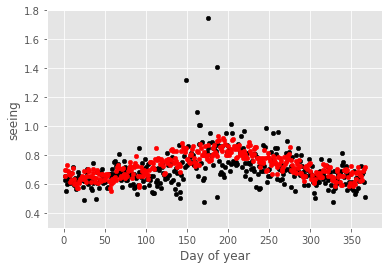

In [9]:
df = ss_seeing.groupby([ss_seeing.dimm_time=='artificial', 'doy'])['seeing'].median().reset_index().set_index('dimm_time')
ax = df.loc[False].plot.scatter('doy', 'seeing', color='k')
df.loc[True].plot.scatter('doy', 'seeing', color='r', ax=ax)
ax.set_ylim(0.3, 1.8)
ax.set_xlabel("Day of year")

Text(0.5, 0, 'Day of year')

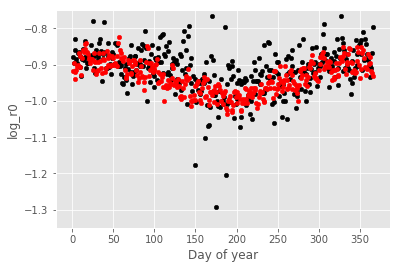

In [10]:
df = ss_seeing.groupby([ss_seeing.dimm_time=='artificial', 'doy'])['log_r0'].median().reset_index().set_index('dimm_time')
ax = df.loc[False].plot.scatter('doy', 'log_r0', color='k')
df.loc[True].plot.scatter('doy', 'log_r0', color='r', ax=ax)
ax.set_ylim(-1.35, -0.75)
ax.set_xlabel("Day of year")

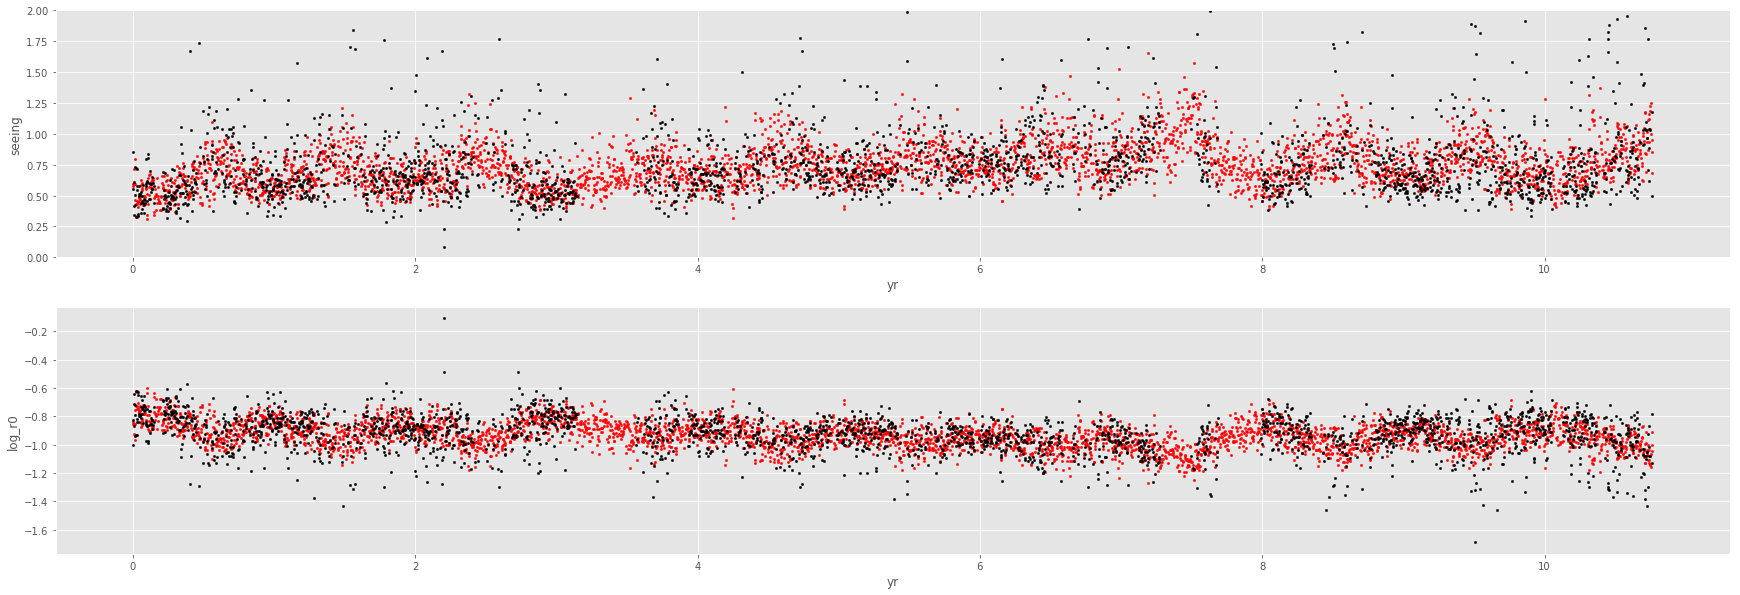

In [11]:
fig, axes = plt.subplots(2, figsize=(30, 10))
df = ss_seeing.groupby([ss_seeing.dimm_time=='artificial', 'night'])['seeing', 'log_r0'].median().reset_index().set_index('dimm_time')
#df.loc[False].plot.scatter('night', 'seeing', color='k', s=5, ax=ax)
df['yr'] = df.night/365.242
df['yr'] = df['yr'] - df['yr'].min()
ax = axes[0]
df.loc[True].plot.scatter('yr', 'seeing', color='r', s=5, ax=ax)
df.loc[False].plot.scatter('yr', 'seeing', color='k', s=5, ax=ax)
ax.set_ylim(0, 2)

ax = axes[1]
df.loc[True].plot.scatter('yr', 'log_r0', color='r', s=5, ax=ax)
df.loc[False].plot.scatter('yr', 'log_r0', color='k', s=5, ax=ax)

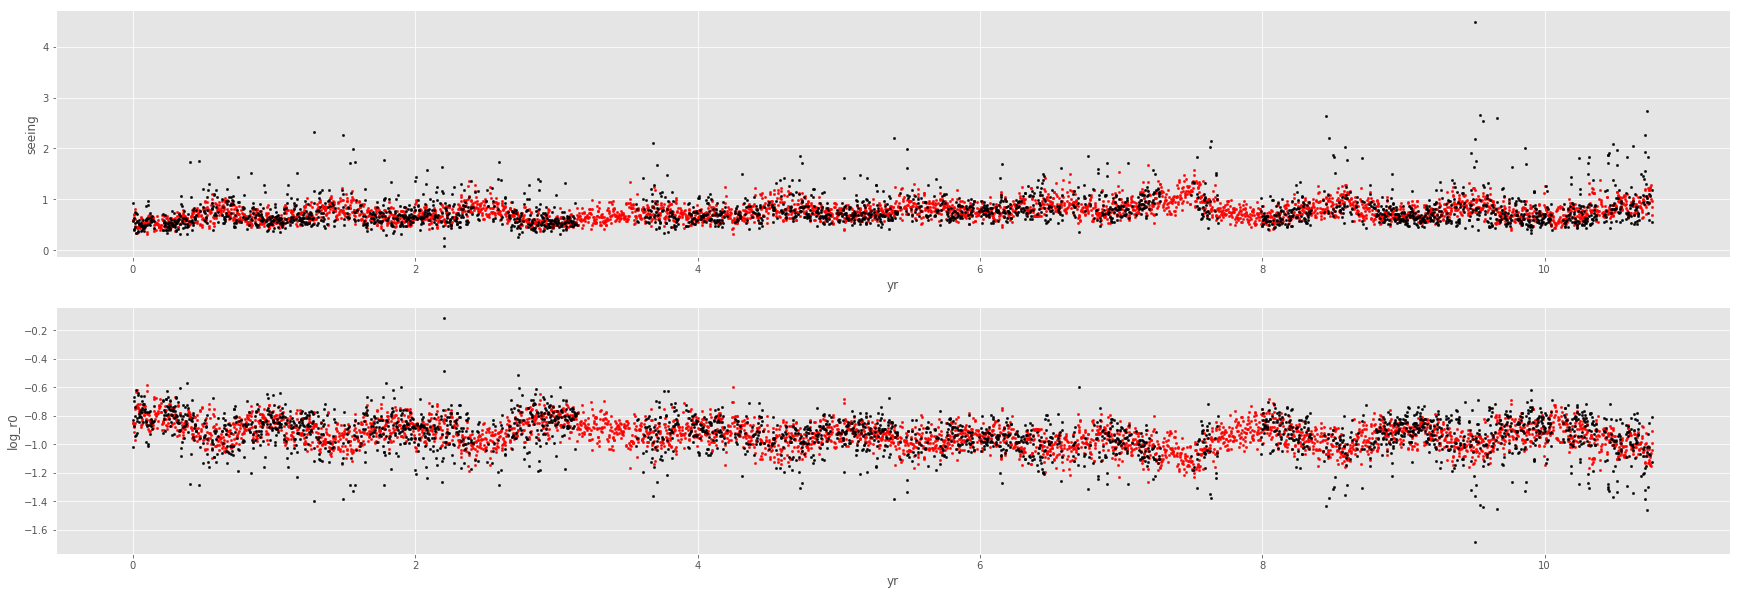

In [12]:
fig, axes = plt.subplots(2, figsize=(30, 10))
df = ss_seeing.groupby([ss_seeing.dimm_time=='artificial', 'night'])['seeing', 'log_r0'].mean().reset_index().set_index('dimm_time')
#df.loc[False].plot.scatter('night', 'seeing', color='k', s=5, ax=ax)
df['yr'] = df.night/365.242
df['yr'] = df['yr'] - df['yr'].min()
ax = axes[0]
df.loc[True].plot.scatter('yr', 'seeing', color='r', s=5, ax=ax)
df.loc[False].plot.scatter('yr', 'seeing', color='k', s=5, ax=ax)

ax = axes[1]
df.loc[True].plot.scatter('yr', 'log_r0', color='r', s=5, ax=ax)
df.loc[False].plot.scatter('yr', 'log_r0', color='k', s=5, ax=ax)

In [13]:
def make_quant_fn(q):
    fn = partial(np.quantile, q=q)
    fn.__name__ = f'{int(100*q)}%'
    return fn

data_stats = [make_quant_fn(q) for q in (0.05, 0.25, 0.5, 0.75, 0.95)]

dimm_bymonth = dimm.groupby('data_month').agg({'month': 'median',
                                             'year': 'median',
                                             'time': ['min', 'max'],
                                             'fwhm': data_stats,
                                             'r0': data_stats,
                                             'log_r0': data_stats,
                                             'vk_seeing': data_stats,
                                             'strehl': data_stats})
dimm_bymonth.head()

/data/des70.a/data/neilsen/anaconda/envs/ehn37/lib/python3.7/site-packages/numpy/lib/function_base.py:3826: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


month   year                      time                            \
           median median                       min                       max   
data_month                                                                     
3               3   2004 2004-03-17 02:33:15+00:00 2004-03-26 10:10:39+00:00   
4               4   2004 2004-04-08 00:13:59+00:00 2004-04-21 03:20:35+00:00   
5               5   2004 2004-05-06 22:47:26+00:00 2004-05-29 09:11:58+00:00   
6               6   2004 2004-06-03 23:46:06+00:00 2004-06-30 23:59:40+00:00   
7               7   2004 2004-07-01 00:00:51+00:00 2004-07-20 04:09:19+00:00   

             fwhm                                r0  ... vk_seeing            \
               5%   25%   50%   75%   95%        5%  ...        5%       25%   
data_month                                           ...                       
3           0.520  0.61  0.69  0.78  1.01  0.100069  ...  0.415013  0.494447   
4           0.540  0.70  0.87  1.05  1.34  0.075425  ...  0.432611  0.574435   
5           0.579  0.85  1.05  1.29  1.94  0.052098  ...  0.467018  0.708734   
6           0.580  1.04  1.53  1.96  2.43  0.041592  ...  0.467902  0.880231   
7           0.510  0.82  1.06  1.28  1.66  0.060885  ...  0.406227  0.681788   

                                          strehl                         \
                 50%       75%       95%      5%    25%     50%     75%   
data_month                                                                
3           0.565524  0.645924  0.853065  0.0000  0.000  0.0000  0.0000   
4           0.726720  0.889293  1.153353  0.0000  0.000  0.0000  0.0000   
5           0.889293  1.107667  1.705448  0.1975  0.282  0.3530  0.4125   
6           1.327467  1.723953  2.160261  0.2275  0.263  0.2995  0.3600   
7           0.898358  1.098537  1.447010  0.2540  0.348  0.4080  0.4435   

                     
                95%  
data_month           
3           0.00000  
4           0.00000  
5           0.47255  
6           0.43250  
7           0.48000  

[5 rows x 29 columns]

In [14]:
def calc_ss_monthly(years_offset):
    fname = os.path.join(data_dir, f'simsee_pachon_58779_{years_offset}.txt.xz')
    mjd_offset = int(round(365.24217*years_offset))
    ss = pd.read_csv(fname, sep="\t")
    ss['log_r0'] = np.log10(ss.r0)
    
    mjd_offset = int(round(365.24217*years_offset))
    ss['mjd'] = ss['mjd'] - mjd_offset
    ss['date'] = pd.to_datetime(ss.mjd + 2400000.5, unit='D', origin='julian', utc=True)
    ss.set_index('date', drop=False, inplace=True)
    ss.index.name = 't'
    
    ss['month'] = ss.index.month
    ss['year'] = ss.index.year
    ss['data_month'] = 12*(ss.year - np.min(dimm.year)) + ss.month

    # night is like mjd, but shifts the rollover to be noon, mean local solar time
    site_longitude_deg = EarthLocation.of_site('Cerro Pachon').lon.deg
    site_night_shift = (180.0 + site_longitude_deg)/360.0
    ss['night'] = np.floor(ss.mjd + site_night_shift).astype(int)
    ss['am'] = ((ss.mjd + site_night_shift) % 1) > 0.5
    
    ss['vk_seeing'] = ss['seeing']
    ss['seeing'] = ss['kol_seeing']
    
    ss_bymonth = ss.groupby('data_month').agg({'month': 'median',
                                               'year': 'median',
                                               'date': ['min', 'max'],
                                               'r0': data_stats,
                                               'log_r0': data_stats,
                                               'vk_seeing': data_stats,
                                               'seeing': data_stats})
    
    return ss_bymonth

offset_years = (13, 16)
ss_monthly = {yo: calc_ss_monthly(yo) for yo in offset_years}

In [15]:
ss_monthly[16].head()

month   year                                date  \
           median median                                 min   
data_month                                                     
25              1   2006           2006-01-01 00:00:00+00:00   
26              2   2006 2006-02-01 00:03:11.999980800+00:00   
27              3   2006 2006-03-01 00:00:23.000025599+00:00   
28              4   2006 2006-04-01 00:04:11.000035200+00:00   
29              5   2006 2006-05-01 00:04:08.999961600+00:00   

                                                      r0                      \
                                           max        5%       25%       50%   
data_month                                                                     
25                   2006-01-31 23:58:12+00:00  0.087631  0.118906  0.142352   
26         2006-02-28 23:55:23.000044800+00:00  0.083529  0.111400  0.132987   
27         2006-03-31 23:59:11.000054400+00:00  0.085110  0.115393  0.140375   
28         2006-04-30 23:59:08.999980800+00:00  0.085652  0.113562  0.136503   
29            2006-05-31 23:57:22.999968+00:00  0.088958  0.117105  0.138452   

                                  log_r0  ... vk_seeing                      \
                 75%       95%        5%  ...        5%       25%       50%   
data_month                                ...                                 
25          0.169164  0.219717 -1.057343  ...  0.362429  0.483348  0.583353   
26          0.156175  0.198176 -1.078164  ...  0.406227  0.527411  0.628021   
27          0.165688  0.220747 -1.070019  ...  0.360555  0.494447  0.592276   
28          0.158909  0.206265 -1.067261  ...  0.388680  0.517522  0.610514   
29          0.163016  0.202613 -1.050814  ...  0.396424  0.503309  0.601204   

                               seeing                            
                 75%       95%     5%   25%   50%   75%     95%  
data_month                                                       
25          0.708734  0.983138   0.46  0.60  0.71  0.85  1.1505  
26          0.760281  1.034699   0.51  0.65  0.76  0.91  1.2100  
27          0.732007  1.014224   0.46  0.61  0.72  0.88  1.1900  
28          0.744723  1.007379   0.49  0.64  0.74  0.89  1.1800  
29          0.720489  0.967489   0.50  0.62  0.73  0.86  1.1400  

[5 rows x 24 columns]

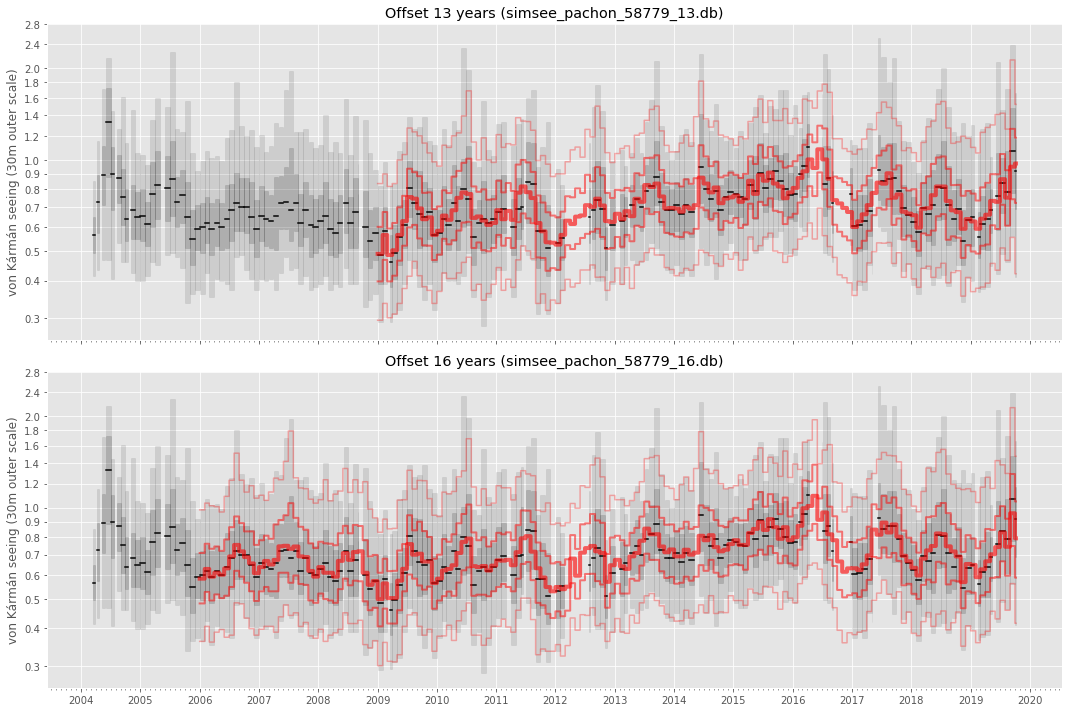

In [26]:
cols = ['vk_seeing', 'vk_seeing']
ncols = len(cols)
fig, axes = plt.subplots(ncols, figsize=(15, 5*ncols), sharex=True)
for ax, col in zip(axes, cols):
    for _, dimm_bymonth_seq in dimm_bymonth.groupby('data_month'):
        df = pd.concat([
            dimm_bymonth_seq.set_index(('time', 'min')).copy(),
            dimm_bymonth_seq.set_index(('time', 'max')).copy()
        ]).sort_index()

        ax.fill_between(df.index, df[(col, '5%')], df[(col, '95%')], color='k', alpha=0.10)
        ax.fill_between(df.index, df[(col, '25%')], df[(col, '75%')], color='k', alpha=0.15)
        ax.plot(df.index, df[(col, '50%')], color='k')
        ax.set_ylabel(col)
    
ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())

ax = axes[0]
ax.set_yscale('log')

for ax, year_offset in zip(axes, ss_monthly.keys()):
    ssm = ss_monthly[year_offset]
    df = pd.concat([
        ssm.set_index(('date', 'min')).copy(),
        ssm.set_index(('date', 'max')).copy()
        ]).sort_index()
    ax.plot(df.index, df[('vk_seeing', '5%')], color='r', alpha=0.3)
    ax.plot(df.index, df[('vk_seeing', '25%')], color='r', alpha=0.5, linewidth=2)
    ax.plot(df.index, df[('vk_seeing', '50%')], color='r', alpha=0.6, linewidth=4)
    ax.plot(df.index, df[('vk_seeing', '75%')], color='r', alpha=0.5, linewidth=2)
    ax.plot(df.index, df[('vk_seeing', '95%')], color='r', alpha=0.3)
    ax.set_title(f'Offset {year_offset} years (simsee_pachon_58779_{year_offset}.db)')
    ax.set_ylabel('von Kármán seeing (30m outer scale)')
    
for ax in (axes[0], axes[1]):
    ax.set_yscale('log')
    ax.set_yticks(list(np.arange(0.3, 1.0, 0.1)) + list(np.arange(1.0, 2.0, 0.2)) + list(np.arange(2.0, 3.0, 0.4)))
    ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.tight_layout()

In [17]:
years_offset = 16
opsim_seeingdb_fname = os.path.join(data_dir, 'seeing.db')
with sqlite3.connect(opsim_seeingdb_fname) as conn:
    opsim_seeingdb = pd.read_sql_query('SELECT * FROM Seeing', conn)
    opsim_seeingdb.index = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(opsim_seeingdb.s_date, unit='s')
    opsim_seeingdb['month'] = opsim_seeingdb.index.month
    opsim_seeingdb['year'] = opsim_seeingdb.index.year
    mjd_offset = int(round(365.24217*years_offset))
    opsim_seeingdb['mjd'] = opsim_seeingdb.index.to_julian_date() - 2400000.5 - mjd_offset
    opsim_seeingdb['night'] = np.floor(opsim_seeingdb.mjd + site_night_shift).astype(int)
    opsim_seeingdb['date'] = pd.to_datetime(opsim_seeingdb.mjd + 2400000.5, unit='D', origin='julian', utc=True)
    opsim_seeingdb['vk_seeing'] = opsim_seeingdb.seeing
    opsim_seeingdb['data_month'] = 12*(opsim_seeingdb.year - np.min(dimm.year)) + opsim_seeingdb.month

opsim_seeingdb.head()

,seeingId,s_date,seeing,month,year,mjd,night,date,vk_seeing,data_month
s_date,,,,,,,,,,
2020-01-01 00:00:00+00:00,1,0,0.782576,1,2020,53005.000000,53005,2004-01-01 00:00:00+00:00,0.782576,193
2020-01-01 00:05:00+00:00,2,300,0.872810,1,2020,53005.003472,53005,2004-01-01 00:04:59.999980800+00:00,0.872810,193
2020-01-01 00:10:00+00:00,3,600,0.746893,1,2020,53005.006944,53005,2004-01-01 00:09:59.999961600+00:00,0.746893,193
2020-01-01 00:15:00+00:00,4,900,0.851306,1,2020,53005.010417,53005,2004-01-01 00:15:00.000028799+00:00,0.851306,193
2020-01-01 00:20:00+00:00,5,1200,0.720582,1,2020,53005.013889,53005,2004-01-01 00:20:00.000009600+00:00,0.720582,193


In [18]:
opsim_bymonth = opsim_seeingdb.groupby('data_month').agg({'month': 'median',
                                                          'year': 'median',
                                                          'date': ['min', 'max'],
                                                          'vk_seeing': data_stats})

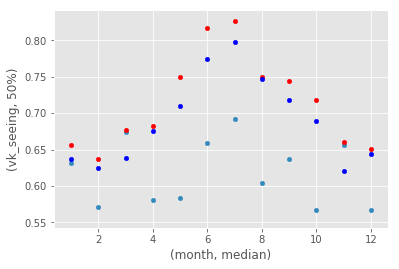

In [19]:
fig, ax = plt.subplots(1)
opsim_seeingdb.groupby('month')['vk_seeing', 'mjd'].median().reset_index().plot.scatter('month', 'vk_seeing', ax=ax)
ss_color = {13: 'r', 16: 'b'}
for year_offset in (13, 16):
    ss_monthly[year_offset].groupby([('month', 'median')]).median().reset_index().plot.scatter(('month', 'median'), ('vk_seeing', '50%'), ax=ax, color=ss_color[year_offset])

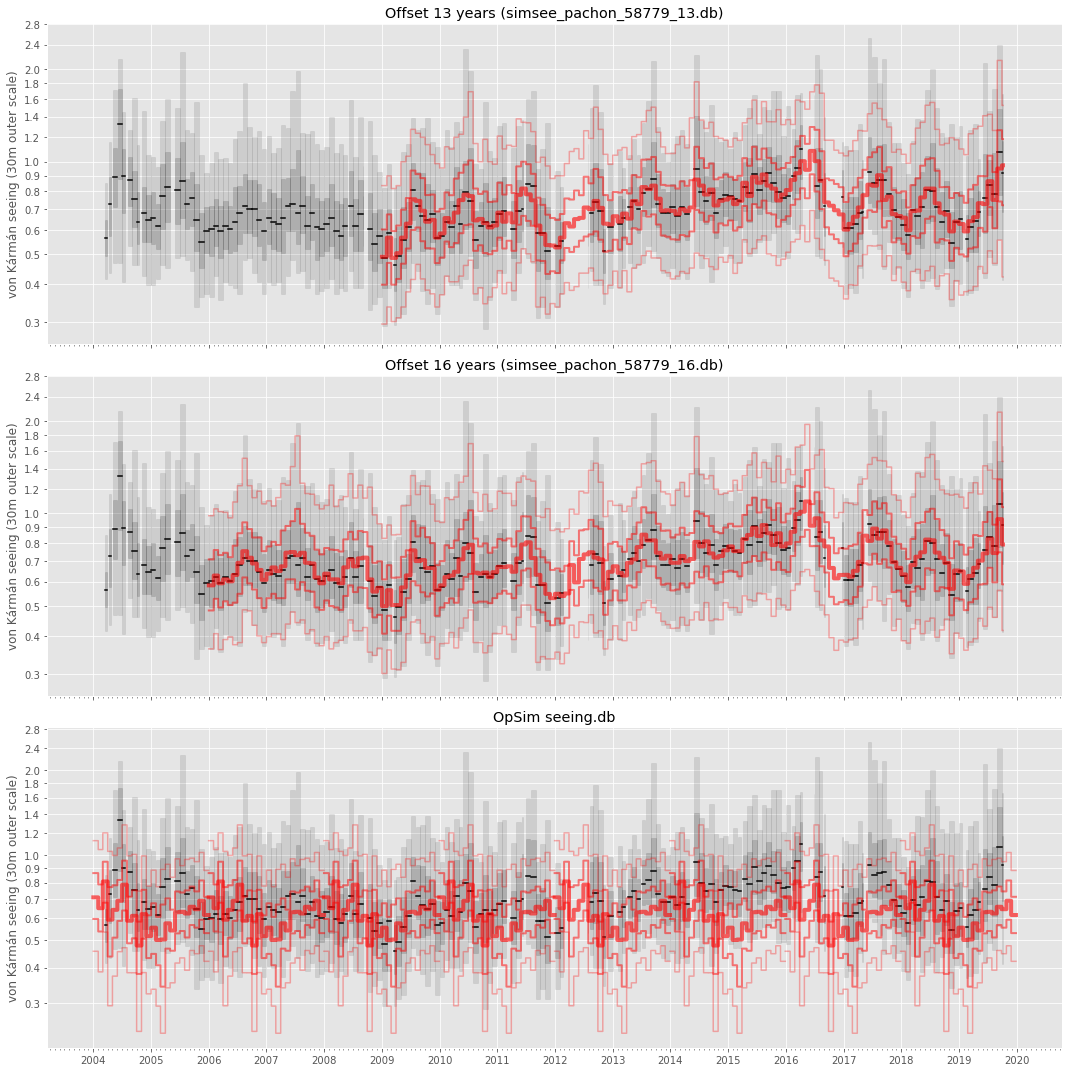

In [29]:
cols = ['vk_seeing', 'vk_seeing', 'vk_seeing']
ncols = len(cols)
fig, axes = plt.subplots(ncols, figsize=(15, 15), sharex=True)
for ax, col in zip(axes, cols):
    for _, dimm_bymonth_seq in dimm_bymonth.groupby('data_month'):
        df = pd.concat([
            dimm_bymonth_seq.set_index(('time', 'min')).copy(),
            dimm_bymonth_seq.set_index(('time', 'max')).copy()
        ]).sort_index()

        ax.fill_between(df.index, df[(col, '5%')], df[(col, '95%')], color='k', alpha=0.10)
        ax.fill_between(df.index, df[(col, '25%')], df[(col, '75%')], color='k', alpha=0.15)
        ax.plot(df.index, df[(col, '50%')], color='k')
        ax.set_ylabel(col)
    
ax.xaxis.set_major_locator(mpl.dates.YearLocator())
ax.xaxis.set_major_formatter(mpl.dates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mpl.dates.MonthLocator())

ax = axes[0]
ax.set_yscale('log')

for ax, year_offset in zip(axes, ss_monthly.keys()):
    ssm = ss_monthly[year_offset]
    df = pd.concat([
        ssm.set_index(('date', 'min')).copy(),
        ssm.set_index(('date', 'max')).copy()
        ]).sort_index()
    ax.plot(df.index, df[('vk_seeing', '5%')], color='r', alpha=0.3)
    ax.plot(df.index, df[('vk_seeing', '25%')], color='r', alpha=0.5, linewidth=2)
    ax.plot(df.index, df[('vk_seeing', '50%')], color='r', alpha=0.6, linewidth=4)
    ax.plot(df.index, df[('vk_seeing', '75%')], color='r', alpha=0.5, linewidth=2)
    ax.plot(df.index, df[('vk_seeing', '95%')], color='r', alpha=0.3)
    ax.set_title(f'Offset {year_offset} years (simsee_pachon_58779_{year_offset}.db)')
    ax.set_ylabel('von Kármán seeing (30m outer scale)')
    
ax = axes[2]
for td_years in np.arange(0, 16, 2):
    shifted_opsim_bymonth = opsim_bymonth.copy()
    shifted_opsim_bymonth['date'] = opsim_bymonth['date'] + pd.Timedelta(f'{td_years*365} days')
    df = pd.concat([
        shifted_opsim_bymonth.set_index(('date', 'min')).copy(),
        shifted_opsim_bymonth.set_index(('date', 'max')).copy()]).sort_index()
    ax.plot(df.index, df[('vk_seeing', '5%')], color='r', alpha=0.3)
    ax.plot(df.index, df[('vk_seeing', '25%')], color='r', alpha=0.5, linewidth=2)
    ax.plot(df.index, df[('vk_seeing', '50%')], color='r', alpha=0.6, linewidth=4)
    ax.plot(df.index, df[('vk_seeing', '75%')], color='r', alpha=0.5, linewidth=2)
    ax.plot(df.index, df[('vk_seeing', '95%')], color='r', alpha=0.3)
    ax.set_title(f'OpSim seeing.db')
    ax.set_ylabel('von Kármán seeing (30m outer scale)')
    
for ax in axes:
    ax.set_yscale('log')
    ax.set_yticks(list(np.arange(0.3, 1.0, 0.1)) + list(np.arange(1.0, 2.0, 0.2)) + list(np.arange(2.0, 3.0, 0.4)))
    ax.get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.tight_layout()

In [21]:
def calc_ss(years_offset):
    fname = os.path.join(data_dir, f'simsee_pachon_58779_{years_offset}.db')
    with sqlite3.connect(fname) as conn:
        ss = pd.read_sql_query('SELECT * FROM Seeing', conn)
        ss.index = pd.to_datetime('2020-01-01T00:00:00Z') + pd.to_timedelta(ss.s_date, unit='s')
        ss['month'] = ss.index.month
        ss['year'] = ss.index.year
        mjd_offset = int(round(365.24217*years_offset))
        ss['mjd'] = ss.index.to_julian_date() - 2400000.5 - mjd_offset
        ss['night'] = np.floor(ss.mjd + site_night_shift).astype(int)
        ss['date'] = pd.to_datetime(ss.mjd + 2400000.5, unit='D', origin='julian', utc=True)
        ss['vk_seeing'] = ss.seeing
        ss['data_month'] = 12*(ss.year - np.min(dimm.year)) + ss.month
        return ss

offset_years = (13, 16)
ss = {yo: calc_ss(yo) for yo in offset_years}

(0.2, 2)

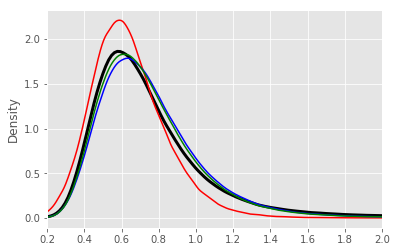

In [22]:
fig, ax = plt.subplots(1)
dimm['vk_seeing'].plot.kde(ax=ax, color='k', linewidth=3)
opsim_seeingdb['vk_seeing'].plot.kde(ax=ax, color='r')
ss[13]['vk_seeing'].plot.kde(ax=ax, color='b')
ss[16]['vk_seeing'].plot.kde(ax=ax, color='g')
ax.set_xlim(0.2, 2)

In [23]:
np.radians(1/(60*60.0))

4.84813681109536e-06

In [24]:
np.degrees(1)*60*60*10**-7

0.020626480624709634

In [25]:
(0.976-0.98)/0.976

-0.004098360655737709